## Sentiment Analysis of Large Movie Dataset

In [1]:
import pandas as pd
import numpy as np
#for preprocessing:
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import matplotlib.pyplot as plt

C:\Users\rania\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: thinc.extra.search.Beam size changed, may indicate binary incompatibility. Expected 112 from C header, got 120 from PyObject
  return f(*args, **kwds)


#### Looks like the distribution of positive and negative examples are almost equal:

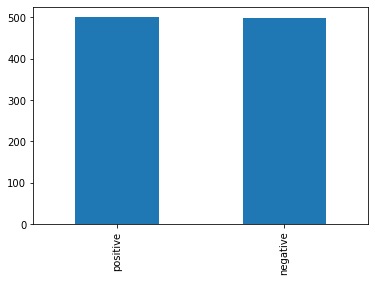

In [2]:
data1 = pd.read_csv("IMDB Dataset.csv",header=None)
data = data1.iloc[1:1000,0]
#plotting the graph about target variable
data1.iloc[1:1000,1].value_counts().plot(kind='bar')

#### Adding length and punctuation to see if thers any correlation with target variable:

In [ ]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
punctuation = ['.',',','?','!',';',':','-','_','{}','[]','()','\'','\""','...',"''"]
review=[]
length=[]
punc_count=[]
for i in range(1,len(data)+1):
    reviews = [REPLACE_NO_SPACE.sub("", data[i].lower()) ]
    reviews = [REPLACE_WITH_SPACE.sub(" ",data[i].lower())] 
    review.append(reviews)
    for j in range(len(reviews)):
        length.append(len(reviews[j]))
    doc = nlp(str(reviews)) 
    k=0
    for token in doc:
        if (token.text in punctuation):
            k=k+1
    punc_count.append(k)
print(len(length))
print(len(punc_count))

#### Rearranging data and adding updated review:

In [ ]:
df=data1.rename({0: "review", 1: "sentiment"},axis='columns')
df = df.drop(columns=['review'])
df = df.iloc[1:1000,:]
#data1=data1.rename({0: "review", 1: "sentiment", 2: "punctuation", 3:"length"},axis='columns')
#data1 = data1.drop(['review'],axis=1)
df.loc[1:1000,2] = punc_count
df.loc[1:1000,3] = length
df.loc[1:1000,4] = review
df=df.rename({ 2: "punctuation", 3:"length",4:"review"},axis='columns')

In [ ]:

%matplotlib inline

plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df[df.iloc[:,0]=='positive'].iloc[:,2],bins=bins,alpha=0.8)
plt.hist(df[df.iloc[:,0]=='negative'].iloc[:,2],bins=bins,alpha=0.8)
plt.legend(('positive','negative'))
plt.show()

####  Negative reviews kind of appear to be longer which does make sense!


In [ ]:
%matplotlib inline

plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df[df.iloc[:,0]=='positive'].iloc[:,1],bins=bins,alpha=0.8)
plt.hist(df[df.iloc[:,0]=='negative'].iloc[:,1],bins=bins,alpha=0.8)
plt.legend(('positive','negative'))
plt.show()

#### Punctuations dont give out any difference! 

In [ ]:
from sklearn.model_selection import train_test_split
#X is our feature data
X=df[['punctuation','length']] 
y = df['sentiment']
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='lbfgs')
lr_model.fit(X_train, y_train)

In [ ]:
from sklearn import metrics

# Create a prediction set:
predictions = lr_model.predict(X_test)
df_output = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['positive','negative'], columns=['positive','negative'])
df_output


#### The Logistic regression isn't doing well with the predictions(equally falsely predicted with correctly predicted)!

In [ ]:
print(metrics.classification_report(y_test,predictions))

#### The classifier works good only for negative class !

In [ ]:
from sklearn.svm import SVC
svc_model = SVC(gamma='auto')
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)
df_output = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['positive','negative'], columns=['positive','negative'])
df_output

### Till now we have used only length and punctuation to predict! Since it isnt working weel lets use Text extraction feature to get some meaning from the review

In [ ]:
X=df['review']
y = df['sentiment']
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

In [ ]:
# Form a prediction set
predictions = text_clf.predict(X_test)

#### We can see that Text extraction feature is useful!

In [ ]:
# Report the confusion matrix
from sklearn import metrics
df_output1 = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['positive','negative'], columns=['positive','negative'])
print(df_output1)
# Print a classification report
print(metrics.classification_report(y_test,predictions))

In [ ]:
print(metrics.accuracy_score(y_test,predictions))

#### Performing Sentiment Analysis:

In [ ]:
import nltk
nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [ ]:
a = 'This was a good movie.'
sid.polarity_scores(a)

In [ ]:
df['scores'] = df['review'].apply(lambda review: sid.polarity_scores(review))

df.head()

In [ ]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()

In [ ]:
df['comp_score'] = df['compound'].apply(lambda c: 'positive' if c >=0 else 'negative')

df.head()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

#### The accuracy isnt impressive as it was in TF-IDFVector which makes sense we didnt actually train any data and Vader cant depict Sarcasm!!

In [ ]:
accuracy_score(df['sentiment'],df['comp_score'])

In [ ]:
print(classification_report(df['sentiment'],df['comp_score']))

In [ ]:
print(confusion_matrix(df['sentiment'],df['comp_score']))